#Introduction

In this notebook we will use a clustering algorithm to analyze our data (i.e. YouTube comments of a single video).
This will help us extract topics of discussion.
We use the embeddings generated in Assignment 4 as input. 
(This notebook will not run without first running the assignment 4 Notebook, as it relies on the data in the folder 'output/')
Each of our comments has been assigned a vector that encodes information about its meaning.
The closer two vectors are, the more similar the meaning.

Each vector is of 512 Dimensions.

Before we can cluster our data we need to reduce the embeddings' dimensionality to overcome the curse of dimensionality.
We use the UMAP ALgorithm for this.

After that we use the KMedoids Algorithm to partition the embedding space and generate our clusters this way.

We need to define the number of clusters we want to have. 
To find the optimal number of clusters, we use a simple optimization scheme.

Once the clusters are created, we visualize them.
To do this we reduce the dimensionality of the embeddings again to two dimensions.
Then we render a scatterplot of our data.

Furthermore we want to analyze and interpret our clusters.
To do this, we:
- print some statistics about each of the clusters
- print cluster's medoid (the central sample)
- print the cluster(s) we want to analyze further

Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [1]:
!which python

/Users/xixuan/opt/anaconda3/envs/criticalMedia/bin/python


# Install dependencies:

In [3]:
install_packages = False
if install_packages:    
    !conda install -c conda-forge umap-learn -y
    !conda install -c conda-forge scikit-learn-extra -y

Solving environment: done

## Package Plan ##

  environment location: /Users/xixuan/opt/anaconda3/envs/criticalMedia

  added / updated specs:
    - umap-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.12.5  |       h033912b_0         138 KB  conda-forge
    certifi-2020.12.5          |   py37hf985489_0         143 KB  conda-forge
    llvmlite-0.35.0            |   py37hd739bdf_0         302 KB  conda-forge
    numba-0.52.0               |   py37h53bd85b_0         3.5 MB  conda-forge
    openssl-1.1.1h             |       haf1e3a3_0         1.9 MB  conda-forge
    tbb-2019.9                 |       ha1b3eb9_1         157 KB  conda-forge
    umap-learn-0.4.6           |   py37hc8dfbb8_0         110 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         6.2 MB

The following NE

# Imports

In [4]:
#imports

import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import umap
from sklearn_extra.cluster import KMedoids
import seaborn as sns
#from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

# Functions to Save and load manually

In [5]:
# Save and load your data after clustering

def save_results():
    data.to_pickle(output_path+'data_clustered'+'.pkl')
    
def load_results():
    data = pd.read_pickle(output_path+'data_clustered'+'.pkl')
    

In [7]:
# Set pandas print options
#This will improve readability of printed pandas dataframe.


In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

output_path: Files generated in this notebook will be saved here.

model_type: Define which model was used to produce the embeddings. (Check the name of the .npy-file containing the embeddings)

In [9]:
output_path = "./output/"
model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

# Load Data
Load the preprocessed data as a pandas dataframe.
And load the embeddings as a numpy ndarray (a matrix in our case).

In [10]:
data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
labels_default = np.zeros(len(data.index))-1
data['label_manual'] = labels_default

In [11]:
embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

# Dimensionality reduction with UMAP

We reduce the number of dimensions of our embeddings to make possibly present clusters more pronounced. 
The number of dimensions (num_dimensions) depends on the number of samples

In [12]:
# Set the number of dimensions to reduce to
num_dimensions =100

reducer_clustering = umap.UMAP(n_neighbors=50, 
                     n_components=num_dimensions, 
                     metric='cosine', 
                     #n_epochs=200, 
                     learning_rate=.5,
                     init='spectral', 
                     min_dist=0,
                     #spread=5.0, 
                     #set_op_mix_ratio=1.0, 
                     #local_connectivity=1.0, 
                     #negative_sample_rate=5, 
                     #transform_queue_size=4.0, 
                     force_approximation_algorithm=True, 
                     unique=True)
embeddings_umap = reducer_clustering.fit_transform(embeddings)

# Optimize the Number of Clusters

n_clusters: 2 silhouette_avg: 0.52868295
n_clusters: 102 silhouette_avg: 0.3023348
n_clusters: 202 silhouette_avg: 0.27885103
n_clusters: 302 silhouette_avg: 0.28415832
n_clusters: 402 silhouette_avg: 0.27805457
n_clusters: 502 silhouette_avg: 0.28105167
n_clusters: 602 silhouette_avg: 0.2832585
n_clusters: 702 silhouette_avg: 0.28212577
n_clusters: 802 silhouette_avg: 0.28487155
n_clusters: 902 silhouette_avg: 0.2876811


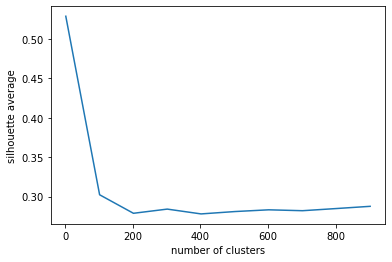

In [13]:
#optimize number of clusters
optimize_number_of_clusters = True#@param {type:'boolean'}

min_clusters=2 
max_clusters=1000 
step=100 

if optimize_number_of_clusters:
    rows_list = []
    inertias = []
    n_clusters = []
    silouette_scores = []
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    random_state_param=1234 #@param {type:'number'}
    for i in range(min_clusters,max_clusters, step):
        temp_clustering = KMedoids(n_clusters=i, metric='euclidean', init=init_param, max_iter=200, random_state=random_state_param).fit(embeddings_umap)
        silhouette_avg = silhouette_score(embeddings_umap, temp_clustering.labels_)
        print("n_clusters:",i, "silhouette_avg:",silhouette_avg)
        silhouette_dict = {'number of clusters': i, 'silhouette average': silhouette_avg}
        rows_list.append(silhouette_dict)
    results = pd.DataFrame(rows_list)
    sns.lineplot(x = 'number of clusters', y = 'silhouette average',data = results)

# Clustering with KMedoids

In [14]:
number_of_clusters =  100
init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
clustering_model = KMedoids(n_clusters=number_of_clusters,
                            metric='cosine', 
                            init=init_param, 
                            max_iter=150, 
                            random_state=None).fit(embeddings_umap)
clustering_model
labels = clustering_model.labels_
data["label_kmedoids"] = labels
print("cluster","members", data["label_kmedoids"].value_counts().sort_values())

clustering_model.inertia_

medoids_indices = clustering_model.medoid_indices_

cluster members 40      8
23      9
49      9
18     11
94     12
82     13
81     13
85     13
71     13
84     13
65     14
79     14
70     16
38     17
48     18
2      19
37     20
89     21
8      21
47     23
83     23
53     24
88     24
87     25
69     25
54     25
75     25
11     25
55     26
74     26
41     27
27     27
45     27
97     27
98     27
78     30
95     30
58     30
67     30
64     30
91     31
63     31
90     31
96     32
66     33
33     33
9      34
10     34
60     35
43     36
14     37
93     38
22     38
56     38
36     38
35     39
17     39
7      40
32     40
86     42
5      42
20     43
30     43
12     43
15     43
80     44
26     44
6      44
51     45
99     45
50     45
31     46
3      46
59     47
46     48
68     49
57     50
76     50
28     51
73     51
19     52
29     55
44     56
25     60
61     65
92     65
13     66
39     67
77     68
34     75
52     75
72     78
1      85
0      86
24     87
62     88
42     96
21    101
16  

In [15]:
#calculate distances
distances = np.diag(pairwise_distances(X = clustering_model.cluster_centers_[labels], Y = embeddings_umap[:], metric='cosine'))
data["distance_kmedoids"] = distances

# Dimensionality Reduction for Visualization

In [16]:
num_dimensions =2

reducer_visualization = umap.UMAP(n_neighbors=50, 
                                  n_components=num_dimensions, 
                                  metric='cosine', 
                                  output_metric='euclidean', 
                                  #n_epochs=200, 
                                  learning_rate=.5,
                                  init='spectral', 
                                  min_dist=.1,
                                  spread=5.0, 
                                  set_op_mix_ratio=1.0, 
                                  local_connectivity=1.0, 
                                  negative_sample_rate=5, 
                                  transform_queue_size=4.0, 
                                  force_approximation_algorithm=True, 
                                  unique=True)
embeddings_umap_2d = reducer_visualization.fit_transform(embeddings)

/Users/xixuan/opt/anaconda3/envs/criticalMedia/lib/python3.7/site-packages/umap/umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


# Visualize clustering results

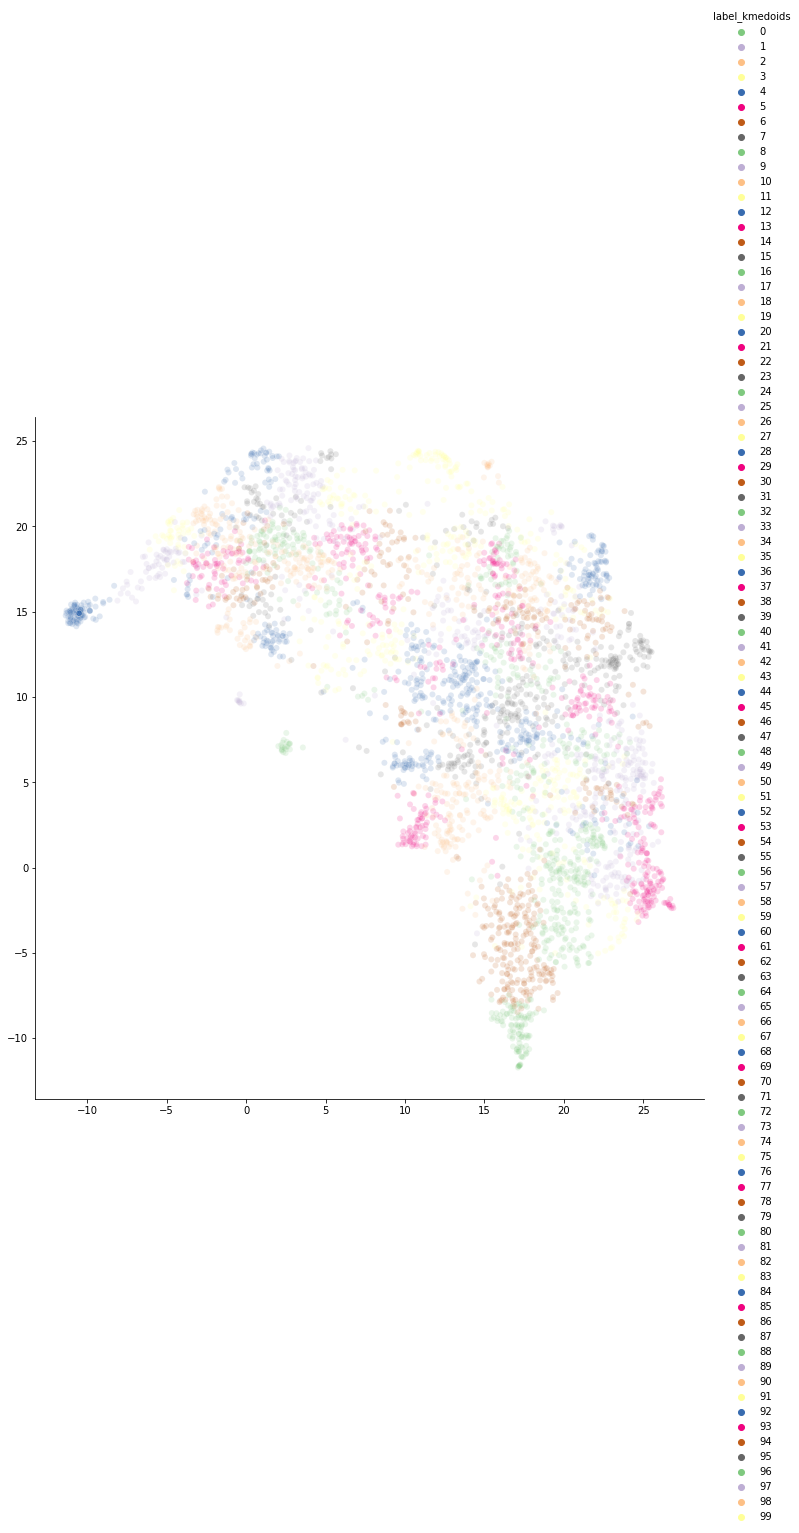

In [17]:
#@markdown Set the color palette used for visualizing different clusters
palette_param = "Accent" #@param ['Accent','cubehelix', "tab10", 'Paired', "Spectral"]
#@markdown Set opacity of data points (1 = opaque, 0 = invisible)
alpha_param = 0.16 #@param {type:"slider", min:0, max:1, step:0.01}


sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['label_kmedoids'], palette = palette_param,alpha = alpha_param,height = 10)


## Highlight one cluster

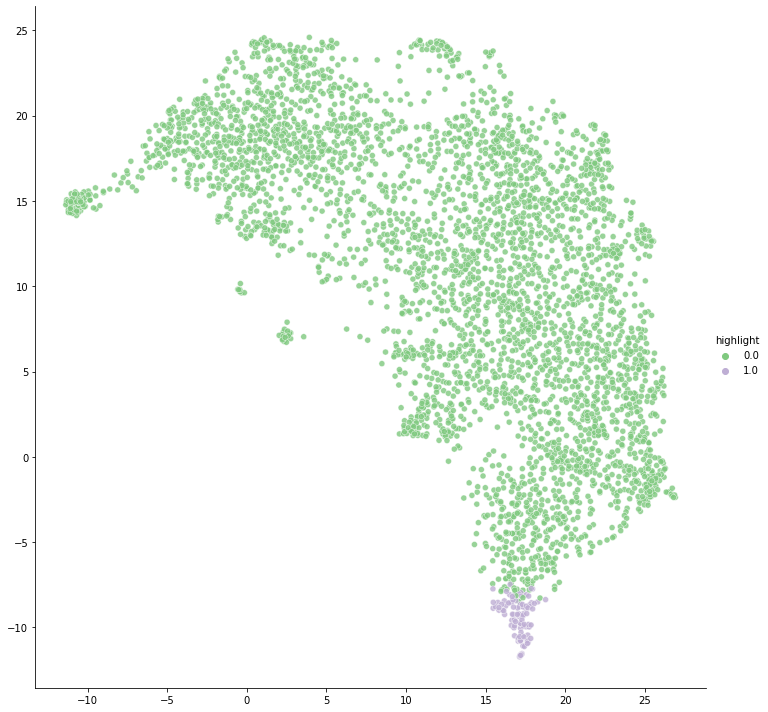

In [19]:
## Choose a cluster to higlight:
cluster_num = 16

data['highlight'] = np.zeros(len(data.index))
data.loc[data['label_kmedoids'] == cluster_num, 'highlight'] = 1

sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)


# Print Medoids and cluster statistics

In [20]:
# print the medoids 
data.iloc[medoids_indices]      

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
2395,2019-05-02 09:01:18,Marcus H,"This is like sayin: <br /><br />&quot;murders, wars, epidemics and so on have alwas existed. And their number was always a little fluctuating. So why make the recent tremendous increase such a big deal?&quot; <br /><br />1. Because people are suffering right now because of climate breakdown and mass extinction. <br />2. The increase in greenhouse gas led to even more temperature increase then scientists predicted 30 years ago. <br />3. It will be come worse and worse and worse if the keep going.<br />4. You can actually measure the greenhouse effect at home if you get yourself a co2-capsule.<br /><br />This is a piece of bought misinformation. You can figure out how the oil, gas and coal industry manipulates you by watching &quot;merchants of doubt&quot;.",0,"This is like sayin: \n \n""murders, wars, epidemics and so on have alwas existed. And their number was\nalways a little fluctuating. So why make the recent tremendous increase such a\nbig deal?"" \n \n1\. Because people are suffering right now because of climate breakdown and\nmass extinction. \n2\. The increase in greenhouse gas led to even more temperature increase then\nscientists predicted 30 years ago. \n3\. It will be come worse and worse and worse if the keep going. \n4\. You can actually measure the greenhouse effect at home if you get yourself\na co2-capsule. \n \nThis is a piece of bought misinformation. You can figure out how the oil, gas\nand coal industry manipulates you by watching ""merchants of doubt"".\n\n",-1.0,0,0.000000e+00,0.0
2386,2019-05-11 23:33:18,marynadononeill,"yes he is, Guy is not quite right in the head...",1,"yes he is, Guy is not quite right in the head...\n\n",-1.0,1,1.192093e-07,0.0
3046,2019-04-25 06:54:17,libertyn jeopardy,As people cease to believe in a creator they tend to believe in the creation without explaining how it all was created.,0,As people cease to believe in a creator they tend to believe in the creation\nwithout explaining how it all was created.\n\n,-1.0,2,2.384186e-07,0.0
2073,2019-10-05 11:31:59,Darrell Knox,"@dasGagaTier World not gonna last decades, contrary to popular belief,need to make sure we are doing the right thing to prepare for unbelievable chaos.",1,"@ World not gonna last decades, contrary to popular belief,need to\nmake sure we are doing the right thing to prepare for unbelievable chaos.\n\n",-1.0,3,1.788139e-07,0.0
3009,2019-04-27 05:01:42,Surfer Culture,Albert Batfinder 🤣🤣,1,🤣🤣\n\n,-1.0,4,0.000000e+00,0.0
286,2019-12-07 21:20:43,John Soos,"Ever notice how ALL of these &quot;climate scientists&quot; (whatever that is) are wrong EVERY FUCKING TIME???? Show me one prediction that ever came to fruition. They&#39;re all in the bag for some government, corporation, etc.",0,"Ever notice how ALL of these ""climate scientists"" (whatever that is) are wrong\nEVERY FUCKING TIME???? Show me one prediction that ever came to fruition.\nThey're all in the bag for some government, corporation, etc.\n\n",-1.0,5,0.000000e+00,0.0
3480,2019-04-28 00:46:03,Anthony Matthews,@jar josh Would this help you to understand? https://www.climate.gov/news-features/climate-tech/climate-core-how-scientists-study-ice-cores-reveal-earth%E2%80%99s-climate,1,@ Would this help you to understand? \nfeatures/climate-tech/climate-core-how-scientists-study-ice-cores-reveal-\nearth%E2%80%99s-climate\n\n,-1.0,6,1.192093e-07,0.0
3602,2019-04-23 15:10:43,Paul John,"His track record in forecasting isn't actually very good, worse actually than a lot of other forecasting outlets, be it up to a month ahead or even a season ahead. His forecasts are only accurate for agriculture and retail.",1,"His track record in forecasting isn't actually very good, worse actually than\na lot of other forecasting outlets, be it up to a month ahead or even a season\nahead. His forecasts are only accurate for agriculture and retail.\n\n

In [24]:
# print statistics for each cluster
data['label_kmedoids'].value_counts().sort_values()
for k,g in data.groupby(by = 'label_kmedoids'):
      print(g.iloc[0]['label_kmedoids'],"number of samples: ",len(g.index),"mean distance from center: ", 100*np.mean(g['distance_kmedoids']), "Proportion of replies:", 100*np.sum(g['isReply'])/len(g.index))

0 number of samples:  86 mean distance from center:  0.0020562216377584264 Proportion of replies: 79.06976744186046
1 number of samples:  85 mean distance from center:  0.0021019402993260883 Proportion of replies: 43.529411764705884
2 number of samples:  19 mean distance from center:  0.001407297077093972 Proportion of replies: 68.42105263157895
3 number of samples:  46 mean distance from center:  0.002158465576940216 Proportion of replies: 71.73913043478261
4 number of samples:  125 mean distance from center:  0.00028543472581077367 Proportion of replies: 70.4
5 number of samples:  42 mean distance from center:  0.0018937247659778222 Proportion of replies: 76.19047619047619
6 number of samples:  44 mean distance from center:  0.0020246614440111443 Proportion of replies: 95.45454545454545
7 number of samples:  40 mean distance from center:  0.001195371169160353 Proportion of replies: 75.0
8 number of samples:  21 mean distance from center:  9.309677579949494e-05 Proportion of replies: 

# Print Cluster
Print the comments within a cluster. Comments are sorted by their distance from the cluster medoid

In [25]:
# Choose a cluster to print
cluster_number =   20
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster


Number of samples in the cluster: 43
Average Distance from cluster center: 5.716501e-06


,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
642,2019-10-13 14:05:36,Charles Kane,Because they don't want you to know how many people like this video because of the common sense and logic this gentleman provides.,1,Because they don't want you to know how many people like this video because of\nthe common sense and logic this gentleman provides.\n\n,-1,20,0.000000e+00,0.0
863,2019-09-28 21:21:33,Dennis Thomas,YouTube will probably deem this video “Hate Speech”.,0,YouTube will probably deem this video “Hate Speech”.\n\n,-1,20,2.384186e-07,0.0
858,2019-09-29 16:43:10,Steve Watson,How many times has this video been reported by douchbags?<br />I notice they&#39;ve removed the thumbs up count for some unknown reason. <br />A scientist speaking facts. <br /><b>TRIGGERED</b>,0,How many times has this video been reported by douchbags? \nI notice they've removed the thumbs up count for some unknown reason. \nA scientist speaking facts. \n**TRIGGERED**\n\n,-1,20,2.980232e-07,0.0
527,2019-10-16 01:18:51,Tara Quinlan,"Why can&#39;t we see likes and dislikes on this video? Come on YouTube, open up to different opinions.. wow..",0,"Why can't we see likes and dislikes on this video? Come on YouTube, open up to\ndifferent opinions.. wow..\n\n",-1,20,5.960464e-07,0.0
840,2019-10-01 16:03:52,Madden71,How come this video doesn&#39;t show the like to dislike numbers?,0,How come this video doesn't show the like to dislike numbers?\n\n,-1,20,6.556511e-07,0.0
841,2019-10-28 08:46:46,Fields,Because the uploader turned them off for this video.,1,Because the uploader turned them off for this video.\n\n,-1,20,7.152557e-07,0.0
1436,2019-06-07 08:45:28,Bruce Posch,"I see 134,000 views but I do not see the tally for &quot;likes&quot; or &quot;dislikes&quot; for this one.",0,"I see 134,000 views but I do not see the tally for ""likes"" or ""dislikes"" for\nthis one.\n\n",-1,20,7.152557e-07,0.0
2621,2019-04-28 18:23:13,Cole Tanner,YouTube should censor this hate speech !!,0,YouTube should censor this hate speech !!\n\n,-1,20,8.344650e-07,0.0
2622,2019-04-28 17:53:42,hipcat13,"Gosh YouTube, why don&#39;t you want to post the likes/dislikes?",0,"Gosh YouTube, why don't you want to post the likes/dislikes?\n\n",-1,20,1.013279e-06,0.0
636,2019-10-11 00:41:14,Paul W,how come we can&#39;t see likes and dislikes ?,0,how come we can't see likes and dislikes ?\n\n,-1,20,1.192093e-06,0.0


# Assign Cluster labels manually
cluster_number: which cluster would you like to assign labels to?
min_distance: the minimum distance from the cluster medoid be for a data point to still get the specified label
max_distance: the maximum distance from the cluster medoid be for a data point to still get the specified label
label_manual: your label

In [26]:
#which cluster would you like to assign labels to?
cluster_number = 20
#your label
label_manual = 'platform_features'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [27]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
642,2019-10-13 14:05:36,Charles Kane,Because they don't want you to know how many people like this video because of the common sense and logic this gentleman provides.,1,Because they don't want you to know how many people like this video because of\nthe common sense and logic this gentleman provides.\n\n,platform_features,20,0.000000e+00,0.0
863,2019-09-28 21:21:33,Dennis Thomas,YouTube will probably deem this video “Hate Speech”.,0,YouTube will probably deem this video “Hate Speech”.\n\n,platform_features,20,2.384186e-07,0.0
858,2019-09-29 16:43:10,Steve Watson,How many times has this video been reported by douchbags?<br />I notice they&#39;ve removed the thumbs up count for some unknown reason. <br />A scientist speaking facts. <br /><b>TRIGGERED</b>,0,How many times has this video been reported by douchbags? \nI notice they've removed the thumbs up count for some unknown reason. \nA scientist speaking facts. \n**TRIGGERED**\n\n,platform_features,20,2.980232e-07,0.0
527,2019-10-16 01:18:51,Tara Quinlan,"Why can&#39;t we see likes and dislikes on this video? Come on YouTube, open up to different opinions.. wow..",0,"Why can't we see likes and dislikes on this video? Come on YouTube, open up to\ndifferent opinions.. wow..\n\n",platform_features,20,5.960464e-07,0.0
840,2019-10-01 16:03:52,Madden71,How come this video doesn&#39;t show the like to dislike numbers?,0,How come this video doesn't show the like to dislike numbers?\n\n,platform_features,20,6.556511e-07,0.0
841,2019-10-28 08:46:46,Fields,Because the uploader turned them off for this video.,1,Because the uploader turned them off for this video.\n\n,platform_features,20,7.152557e-07,0.0
1436,2019-06-07 08:45:28,Bruce Posch,"I see 134,000 views but I do not see the tally for &quot;likes&quot; or &quot;dislikes&quot; for this one.",0,"I see 134,000 views but I do not see the tally for ""likes"" or ""dislikes"" for\nthis one.\n\n",platform_features,20,7.152557e-07,0.0
2621,2019-04-28 18:23:13,Cole Tanner,YouTube should censor this hate speech !!,0,YouTube should censor this hate speech !!\n\n,platform_features,20,8.344650e-07,0.0
2622,2019-04-28 17:53:42,hipcat13,"Gosh YouTube, why don&#39;t you want to post the likes/dislikes?",0,"Gosh YouTube, why don't you want to post the likes/dislikes?\n\n",platform_features,20,1.013279e-06,0.0
636,2019-10-11 00:41:14,Paul W,how come we can&#39;t see likes and dislikes ?,0,how come we can't see likes and dislikes ?\n\n,platform_features,20,1.192093e-06,0.0
